![RAPTOR Overview](../RAPTOR.png)

## Install dependencies

In [1]:
pip install -U langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
import pandas as pd

### Create a function that return number of tokens from string

In [3]:
def num_tokens_from_string(string: str, encoding_name:str) -> int:
    ## We will use tiktoken to get the token details
    encoding= tiktoken.get_encoding(encoding_name)
    num_tokens= len(encoding.encode(string))
    return num_tokens

In [4]:
num_tokens_from_string("Hello, I am Vikas", "cl100k_base")

6

### Get Langchain docs LCEL docs

In [5]:
url= "https://python.langchain.com/docs/expression_language/"
loader= RecursiveUrlLoader(
    url= url,
    max_depth= 20,
    extractor= lambda x:Soup(x, "html.parser").text
)
docs= loader.load()

In [6]:
docs

[Document(page_content='\n\n\n\n\nLangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentLangChain v0.2 is out! You are currently viewing the old v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS Docs💬SearchGet startedIntroductionQuickstartInstallationUse casesQ&A with RAGExtracting structured outputChatbotsTool use and agentsQuery analysisQ&A over SQL + CSVMoreExpression LanguageGet startedRunnable interfacePrimitivesAdvantages of LCELStreamingAdd message history (memory)MoreEcosystem🦜🛠️ LangSmith🦜🕸️LangGraph🦜️🏓 LangServeSecurityExpression LanguageLangChain Expression Language (LCEL)LangChain Expression Language, or LCEL, is a declarative way to easily compose chains together.\nLCEL was designed from day 1 to support putting prototypes in production, with no c

### LCEL with pydantic output parser

In [7]:

url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader= RecursiveUrlLoader(
    url= url,
    max_depth=1,
    extractor= lambda x: Soup(x, "html.parser").text

)
docs_pydantic= loader.load()

In [8]:
docs_pydantic

[Document(page_content='\n\n\n\n\nQuickstart | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentLangChain v0.2 is out! You are currently viewing the old v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS Docs💬SearchModel I/OPromptsChat modelsLLMsOutput parsersQuickstartOutput ParsersCustom Output ParserstypesRetrievalDocument loadersText splittersEmbedding modelsVector storesRetrieversIndexingCompositionToolsAgentsChainsMoreComponentsModel I/OOutput parsersQuickstartOn this pageQuickstartLanguage models output text. But many times you may want to get more structured information than just text back. This is where output parsers come in.Output parsers are classes that help structure language model responses. There are two main methods an output parser must implement:"Get format instructions": A m

#### LCEL with self query

In [9]:

url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader= RecursiveUrlLoader(
    url= url,
    max_depth=1,
    extractor= lambda x: Soup(x, "html.parser").text

)
docs_sq= loader.load()

In [10]:
docs_sq

[Document(page_content='\n\n\n\n\nSelf-querying | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentLangChain v0.2 is out! You are currently viewing the old v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS Docs💬SearchModel I/OPromptsChat modelsLLMsOutput parsersRetrievalDocument loadersText splittersEmbedding modelsVector storesRetrieversVector store-backed retrieverRetrieversMultiQueryRetrieverContextual compressionCustom RetrieverEnsemble RetrieverLong-Context ReorderMultiVector RetrieverParent Document RetrieverSelf-queryingTime-weighted vector store retrieverIndexingCompositionToolsAgentsChainsMoreComponentsRetrievalRetrieversSelf-queryingOn this pageSelf-queryinginfoHead to Integrations for documentation on vector stores with built-in support for self-querying.A self-querying retriever is

### Append all the docs

In [11]:
docs.extend([*docs_pydantic, *docs_sq])
docs_texts= [d.page_content for d in docs]

In [12]:
from pprint import pprint

In [13]:
pprint(docs_texts)

['\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'LangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Skip to main contentLangChain v0.2 is out! You are currently viewing the old '
 'v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI '
 'ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith '
 'DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS '
 'Docs💬SearchGet startedIntroductionQuickstartInstallationUse casesQ&A with '
 'RAGExtracting structured outputChatbotsTool use and agentsQuery analysisQ&A '
 'over SQL + CSVMoreExpression LanguageGet startedRunnable '
 'interfacePrimitivesAdvantages of LCELStreamingAdd message history '
 '(memory)MoreEcosystem🦜🛠️ LangSmith🦜🕸️LangGraph🦜️🏓 '
 'LangServeSecurityExpression LanguageLangChain Expression Language '
 '(LCEL)LangChain Expression Language, or LCEL, is a declarative way to easily '
 'compose chains together.\n'
 'LCEL 

### Calculate No. of tokens for each document

In [14]:
counts= [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]
counts

[774, 1156, 3124]

### Lets plot histogram to that

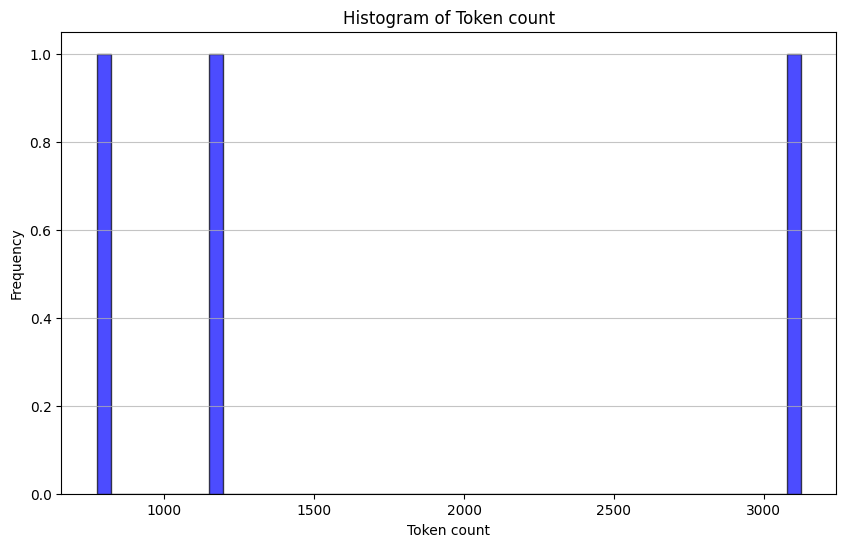

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins= 50, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token count")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [16]:
sum(counts)

5054

#### COncat all the text

In [17]:
d_sorted= sorted(docs, key= lambda x: x.metadata['source'])
d_reversed= list(reversed(d_sorted))
concatenated_content= "\n\n\n ----- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
pprint("Number of tokens in all content: %s"
       % num_tokens_from_string(concatenated_content, "cl100k_base"))

'Number of tokens in all content: 5060'


In [18]:
d_sorted[0].metadata

{'source': 'https://python.langchain.com/docs/expression_language/',
 'content_type': 'text/html; charset=utf-8',
 'title': 'LangChain Expression Language (LCEL) | 🦜️🔗 LangChain',
 'description': 'LangChain Expression Language, or LCEL, is a declarative way to easily compose chains together.',
 'language': 'en'}

#### Document splitting

In [19]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok= 2000
text_splitter= RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size= chunk_size_tok,
                                                                    chunk_overlap=0)

text_splits= text_splitter.split_text(concatenated_content)

In [20]:
pprint(text_splits)

['Quickstart | 🦜️🔗 LangChain\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Skip to main contentLangChain v0.2 is out! You are currently viewing the old '
 'v0.1 docs. View the latest docs here.ComponentsIntegrationsGuidesAPI '
 'ReferenceMorePeopleVersioningContributingTemplatesCookbooksTutorialsYouTubev0.1v0.2v0.1🦜️🔗LangSmithLangSmith '
 'DocsLangServe GitHubTemplates GitHubTemplates HubLangChain HubJS/TS '
 'Docs💬SearchModel I/OPromptsChat modelsLLMsOutput parsersQuickstartOutput '
 'ParsersCustom Output ParserstypesRetrievalDocument loadersText '
 'splittersEmbedding modelsVector '
 'storesRetrieversIndexingCompositionToolsAgentsChainsMoreComponentsModel '
 'I/OOutput parsersQuickstartOn this pageQuickstartLanguage models output '
 'text. But many times you may want to get more structured information than '
 'just text back. This is where output parsers come in.Output parsers are '
 'classes that help structure language model responses. There are two main '
 'methods an output pars

## Setup models

In [21]:
from langchain_openai import OpenAIEmbeddings
embd= OpenAIEmbeddings()

from langchain_openai import ChatOpenAI
model= ChatOpenAI(temperature=0, model= 'gpt-3.5-turbo')

## Tree construction
The clustering approach is following few algorithms

#### GMM (Gaussian Mixture Model)
* Model the distribution of points across different clusters
* Optimal number of clusters by evaluating model's Bayesian Information Criterion (IBC)

### UMAP (Uniform Manifold Approximation and Projection)
* Reduces the dimensionality of high-dimensional data
* supports clustering
* Helps to hilight the natural group of data points based on their similarities

### Local and global clustering
* Used to analyse data and different scales
* Both fine-grained and border patterns within the data points based on siilarities

### Thresholding
* Apply in the context of GMM to determine cluster membership
* Based on the probability distribution (assingment of data points >= 1 cluster)
---
Code for GMM and thresholding is from Sarthi et al, as noted in the below two sources:
* [original repo](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
* [Minor Tweaks](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

Full credit to both the authors



In [22]:
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture
RANDOM_SEED= 224

/Users/vikaslakka/opt/miniconda3/envs/data_privacy/lib/python3.10/site-packages/tqdm-4.66.2-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clustering
* It is basically combining multiple docs of same intention and clubbing them.
* Then create a summary out of those docs
* We will get one more layer of summary
* Combine summaries with same intention
* Create summary from those summary and create one more level.
* Continue untill you get single summary or the same summary

- Use **GMM** as clustering technique
- When using GM you might face slowness due to higher dimensionality
- Hence we use UMAP to reduce dimension and considerably less loss compared to other algos such as PCA, t-SNE
- To Determine optimal number of clusters we use **BIC** as it will penalise model complexity and reward goodness of fit

In [23]:
def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim:int,
    n_neighbors: Optional[int] = None,
    metric: str="cosine",
    ) -> np.ndarray:
    """
    Function definition:
        Perform global dimensionality reduction on the embeddings using UMAP
    Parameters:
    - Embeddings: input embeddings
    - dim: The target dimensionality for reduced space
    - n_neighbors: Optional: Number of neighbors consider for each points.
                             If not specified, it defaults to square root of number of embeddings
    - metric: The distance metric to use for UMAP
    
    returns:
    - A numpy array of the embbedings reduced to the specified dimensionality.        
    """
    if n_neighbors is None:
        n_neighbors= int((len(embeddings)-1) ** 0.5)
    return umap.UMAP(
        n_neighbors= n_neighbors, n_components= dim, metric= metric
    ).fit_transform(embeddings)

In [24]:
def local_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    num_neighbors: int = 10,
    metric: str = "cosine"
    ) -> np.ndarray:
    """
    Funcion definition:
    Perform local dimensionality reduction. Basically creates local clustering inside global clustering

    Parameters:
    - embeddings: input embeddings as numpy array
    - dim: Targer dimensionality for reduced space (to how much dimension do we have to reduce)
    - num_neighbors: Number of neighbors to consider for each point
    - metric: Distance to be used for UMAP

    Returns:
    - A numpy array of embeddings reduced to specified dimensionality.
    """
    return umap.UMAP(n_neighbors=num_neighbors, n_components=dim,
                    metric= metric).fit_transform(embeddings)

In [25]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int= RANDOM_SEED
) -> int:
    """Determine the optimal number of clusters using Bayesian Information Criterion (BIC) with a 
       Gaussian Mixture Model

    Args:
        embeddings (np.ndarray): input embeddings of numpy array
        max_clusters (int, optional): maximum number of clusters to consider. Defaults to 50.
        random_state (int, optional): seed for reproducibility. Defaults to RANDOM_SEED.

    Returns:
        int: result with optimal number of clusters found.
    """
    max_clusters= min(max_clusters, len(embeddings))
    n_clusters= np.arange(1, max_clusters)
    bics= []
    for n in n_clusters:
        gm= GaussianMixture(n_components=n, random_state= random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

**GMM Cluster**

In [26]:
def GMM_cluster(embeddings: np.ndarray, threshold: float,
                random_state: int = RANDOM_SEED) -> Tuple:
    """Cluster embedding using GMM based on probability threshold.

    Args:
        embeddings (np.ndarray): input embeddings as numpy array
        threshold (float): the probability threshold for assigning an embedding to a cluster
        random_state (int, optional): Seed for reproducibility. Defaults to RANDOM_SEED.
    Returns:
            - A tuple containing cluster labels and number of clusters determined.
    """
    ## Get optimal number of clusters using GMM
    n_clusters= get_optimal_clusters(embeddings)
    ##Create labels and clusters using GMM again
    gm= GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs= gm.predict_proba(embeddings)
    labels= [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters
    

In [27]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,    
) -> List[np.ndarray]:
    """Steps:
    1. Perform clustering on embeddings by first reducing dimensionality locally.
    2. Global Clustering using Gaussian Mixture Model.
    3. Performing local clustering within each global cluster.

    Args:
        embeddings (np.ndarray): Input embedding as numpy array
        dim (int): The target dimensionality for UMAP reduction
        threshold (float): The probability threshold for assigning an embedding to a cluster in GMM

    Returns:
        List[np.ndarray]: List of numpy array, where each array contains the cluster Ids for each embedding.
    """
    ## Avoid clustering if there is insufficient data
    if len(embeddings) <= dim +1:
        return [np.array([0]) for _ in range(len(embeddings))]
    
    ## Global Dimensionality reduction
    reduced_embeddings_global= global_cluster_embeddings(embeddings, dim)
    
    ## Global Clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )
    
    all_local_clusters= [np.array([]) for _ in range(len(embeddings))]
    total_clusters=0
    
    ## Iterate through global clustering to perform local clustering
    for i in range(n_global_clusters):
        ## Extract embeddings that belong to global clustes using ids
        global_cluster_embeddings_= embeddings[np.array([i in gc for gc in global_clusters])]
        
        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim+1:
            ## Handle small clusters with direct assignments
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters=1
        else:
            ##Local dimensionality reduction and clustering
            reduced_embeddings_local= local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )
        
        ## Assign local ClusterId, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_= global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j+  total_clusters
                )
        total_clusters += n_local_clusters
    return all_local_clusters
            

In [28]:
def embed(texts: List) -> np.ndarray:
    """Generate embeddings for list of text documents

    Args:
        texts (List): list of Text documents to be embedded

    Returns:
        np.ndarray: array of embeddings for given text documents
    """
    text_embeddings= embd.embed_documents(texts)
    text_embeddings_np= np.array(text_embeddings)
    return text_embeddings_np

In [29]:
def embed_cluster_texts(texts: List):
    """Embedds list of texts and clusters them, return data frame with texts, their embeddins and cluster labels.
    This function combines embedding generation and clustering in a single step. as the function `perform_clustering`
    takes care of clustering on the embeddings

    Args:
        texts (List): list of text documents to be processed.
    
    Returns:
    - Pandas dataframe: Data frame containing original texts, their embeddings and assigned cluster labels.
    """
    text_embeddings_np= embed(texts)## Generate embeddings
    cluster_labels= perform_clustering(text_embeddings_np, 10, 0.1)# Perform clustering on embeddings
    df= pd.DataFrame() ## initialize data frame
    df['text']= texts ## Store original texts
    df['embd']= list(text_embeddings_np)##Embedded text
    df['cluster']= cluster_labels ## Cluster labels
    return df
    
    

### Format text

In [30]:
def fmt_txt(df: pd.DataFrame)-> str:
    """Formats text documents from data frame to text string
    

    Args:
        df (pd.DataFrame): Data frame containing 'text' column with text documents to format
        

    Returns:
        str: Single string where all the text documents are joined by a specific delimeter
    """
    unique_txt= df['text'].tolist()
    return "--- --- \n --- ---".join(unique_txt)

### Embed cluster summarize text

In [31]:
def embed_cluster_summarize_texts(
    texts: List[str],
    level: int,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Embeds, clusters and summarize the list of texts. 
    1. This function first generates embeddings for the texts,
    2. clusters them based on similarity
    3. expands the cluster assignments for easier processing
    4. summarize the content within each cluster.
    

    Args:
        texts (List[str]): A list of text documents to be processed
        level (int): integer that defines the depth or detail of processing

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: 
        1. first data frame: df_clusters: includes original texts, their embeddings and cluster assignments
        2. second data frame: df_summary: contains summaries of each cluster, specified level of detail
            and cluster identifiers
    """
    # Embed and cluster the texts, resulting in a dataframe with 'text', 'embd', and cluster columns
    df_clusters= embed_cluster_texts(texts)
    
    # Prepare to expand the dataframe for easier manipulation of clusters
    expanded_list= []
    
    # Expand DataFrame entries to document-cluster pairings for straight-forward processing
    for index, row in df_clusters.iterrows():
        for cluster in row['cluster']:
            expanded_list.append(
                {"text": row['text'], "embd":row['embd'], "cluster": cluster}
            )
    ## Create new data frame from expanded list
    expanded_df= pd.DataFrame(expanded_list)
    
    # Retrieve unique cluster identifiers from processing
    all_clusters= expanded_df["cluster"].unique()
    
    print(f"---Generated {len(all_clusters)} clusters---")
    
    ## Summarization
    
    template= """
    Here is the sub-set of langchain expression language document.
    Langchain Expression languagee provides a way to compose chain in langchain.
    Give a detailed summary of documentation provided.
    Documentation:
    {context}
    
    """
    prompt= ChatPromptTemplate.from_template(template=template)
    chain= prompt | model | StrOutputParser()
    
    ## Format text within each cluster for summarization
    summaries= []
    
    for i in all_clusters:
        df_cluster= expanded_df[expanded_df["cluster"] == i]
        formatted_txt= fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))
        
    # Creates a dataframe to store summaries with their corresponding cluster and level
    df_summary= pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters)
        }
    )
    
    return df_cluster, df_summary
    

### Recursive embed cluster summarize

In [32]:
def recursive_embed_cluster_summarize(
    texts: List[str],
    level: int =1,
    n_levels: int =3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters and summarizes texts upto a specified level or until the number of
    unique clusters become 1, storing the results at each level.
    
    parameters:
    - texts: texts to be processes
    - level: current recursion level (starts at 1).
    - n_levels: maximum depth of recursion.
    
    Return:
    - Dict[int, Tuple(df, df)]: a dictionary where keys are the recursion levels and 
    values are tuples containing clusters DataFrame and summaries DataFrame at that level.
    """
    
    # Dictionary to store results at each level
    results= {}
    
    # Perform embedding, clustering, and summarizatoin for current level
    df_clusters, df_summary= embed_cluster_summarize_texts(texts, level)
    
    # Store the results of the current level
    results[level]= (df_clusters, df_summary)
    
    # Determine further recursion is possible and meaningful
    unique_clusters= df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters >1:
        # Use summaries as the input texts for the next level of recursion
        new_texts= df_summary["summaries"].tolist()
        next_level_results= recursive_embed_cluster_summarize(
            new_texts, level+1, n_levels
        )
        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)
    return results

## Lets execute

In [67]:
leaf_texts= docs_texts
results= recursive_embed_cluster_summarize(leaf_texts, level=3, n_levels=5)

---Generated 1 clusters---


In [34]:
type(results)

dict

In [71]:
results[3]

(                                                text  \
 0  \n\n\n\n\nLangChain Expression Language (LCEL)...   
 1  \n\n\n\n\nQuickstart | 🦜️🔗 LangChain\n\n\n\n\n...   
 2  \n\n\n\n\nSelf-querying | 🦜️🔗 LangChain\n\n\n\...   
 
                                                 embd  cluster  
 0  [0.011032938733163685, 0.02104789339824041, -0...        0  
 1  [-0.0013542183668599336, 0.029847933478814564,...        0  
 2  [-0.01196943593841365, 0.02822730685137361, -0...        0  ,
                                            summaries  level  cluster
 0  The Langchain Expression Language (LCEL) is a ...      3        0)

In [73]:
pprint(results[3][1]['summaries'][0])

('The Langchain Expression Language (LCEL) is a declarative way to compose '
 'chains together in Langchain. It was designed to support putting prototypes '
 'into production without code changes, from simple chains to complex chains '
 'with hundreds of steps. Some key features of LCEL include:\n'
 '\n'
 '1. First-class streaming support: LCEL provides the best possible '
 'time-to-first-token, allowing for streaming tokens straight from a language '
 'model to a streaming output parser.\n'
 '2. Async support: Chains built with LCEL can be called synchronously or '
 'asynchronously, enabling the same code to be used for prototypes and '
 'production with great performance.\n'
 '3. Optimized parallel execution: LCEL automatically executes steps that can '
 'be parallelized, reducing latency.\n'
 '4. Retries and fallbacks: Configurable retries and fallbacks make chains '
 'more reliable at scale.\n'
 '5. Access to intermediate results: Users can access intermediate results of '
 'comple